In [1]:
!pip install torch torchvision transformers pytorch-lightning matplotlib


In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from transformers import SegformerFeatureExtractor

class SemanticSegmentationDataset(Dataset):
    """Dataset class for semantic segmentation."""
    def __init__(self, root_dir, feature_extractor):
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        
        self.images = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])
        self.masks = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        # Preprocess using the feature extractor
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")
        for k, v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()  # Remove batch dimension
        return encoded_inputs


In [6]:
# Load the feature extractor
feature_extractor = SegformerFeatureExtractor()

# Define paths to your datasets
train_folder = "/home/kishore/peer_ros2/src/segformer/data2/train"
valid_folder = "/home/kishore/peer_ros2/src/segformer/data2/valid"
test_folder = "/home/kishore/peer_ros2/src/segformer/data2/test"

# Create datasets
train_dataset = SemanticSegmentationDataset(root_dir=train_folder, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=valid_folder, feature_extractor=feature_extractor)
test_dataset = SemanticSegmentationDataset(root_dir=test_folder, feature_extractor=feature_extractor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [7]:
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation

class SegFormerLightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super(SegFormerLightningModule, self).__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, batch):
        images = batch['pixel_values']
        outputs = self.model(images)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        outputs = self(batch)
        outputs_upsampled = F.interpolate(outputs, size=batch['labels'].shape[-2:], mode='bilinear', align_corners=False)
        loss = self.criterion(outputs_upsampled, batch['labels'])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(batch)
        outputs_upsampled = F.interpolate(outputs, size=batch['labels'].shape[-2:], mode='bilinear', align_corners=False)
        loss = self.criterion(outputs_upsampled, batch['labels'])
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        outputs = self(batch)
        outputs_upsampled = F.interpolate(outputs, size=batch['labels'].shape[-2:], mode='bilinear', align_corners=False)
        loss = self.criterion(outputs_upsampled, batch['labels'])
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Load the SegFormer model
model_architecture = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-cityscapes-1024-1024",
    num_labels=3,
    ignore_mismatched_sizes=True
)
model = SegFormerLightningModule(model=model_architecture)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Set up the Trainer
trainer = pl.Trainer(max_epochs=10, devices=1, accelerator='gpu')

# Train the model
trainer.fit(model, train_loader, valid_loader)

# Test the model
trainer.test(model, test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kishore/anaconda3/envs/segformer_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/kishore/anaconda3/envs/segformer_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 22 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/kishore/anaconda3/envs/segformer_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 22 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 129/129 [00:28<00:00,  4.57it/s, loss=0.253, v_num=8]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 129/129 [00:28<00:00,  4.56it/s, loss=0.253, v_num=8]


You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kishore/anaconda3/envs/segformer_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 22 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 13.76it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35008731484413147
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.35008731484413147}]

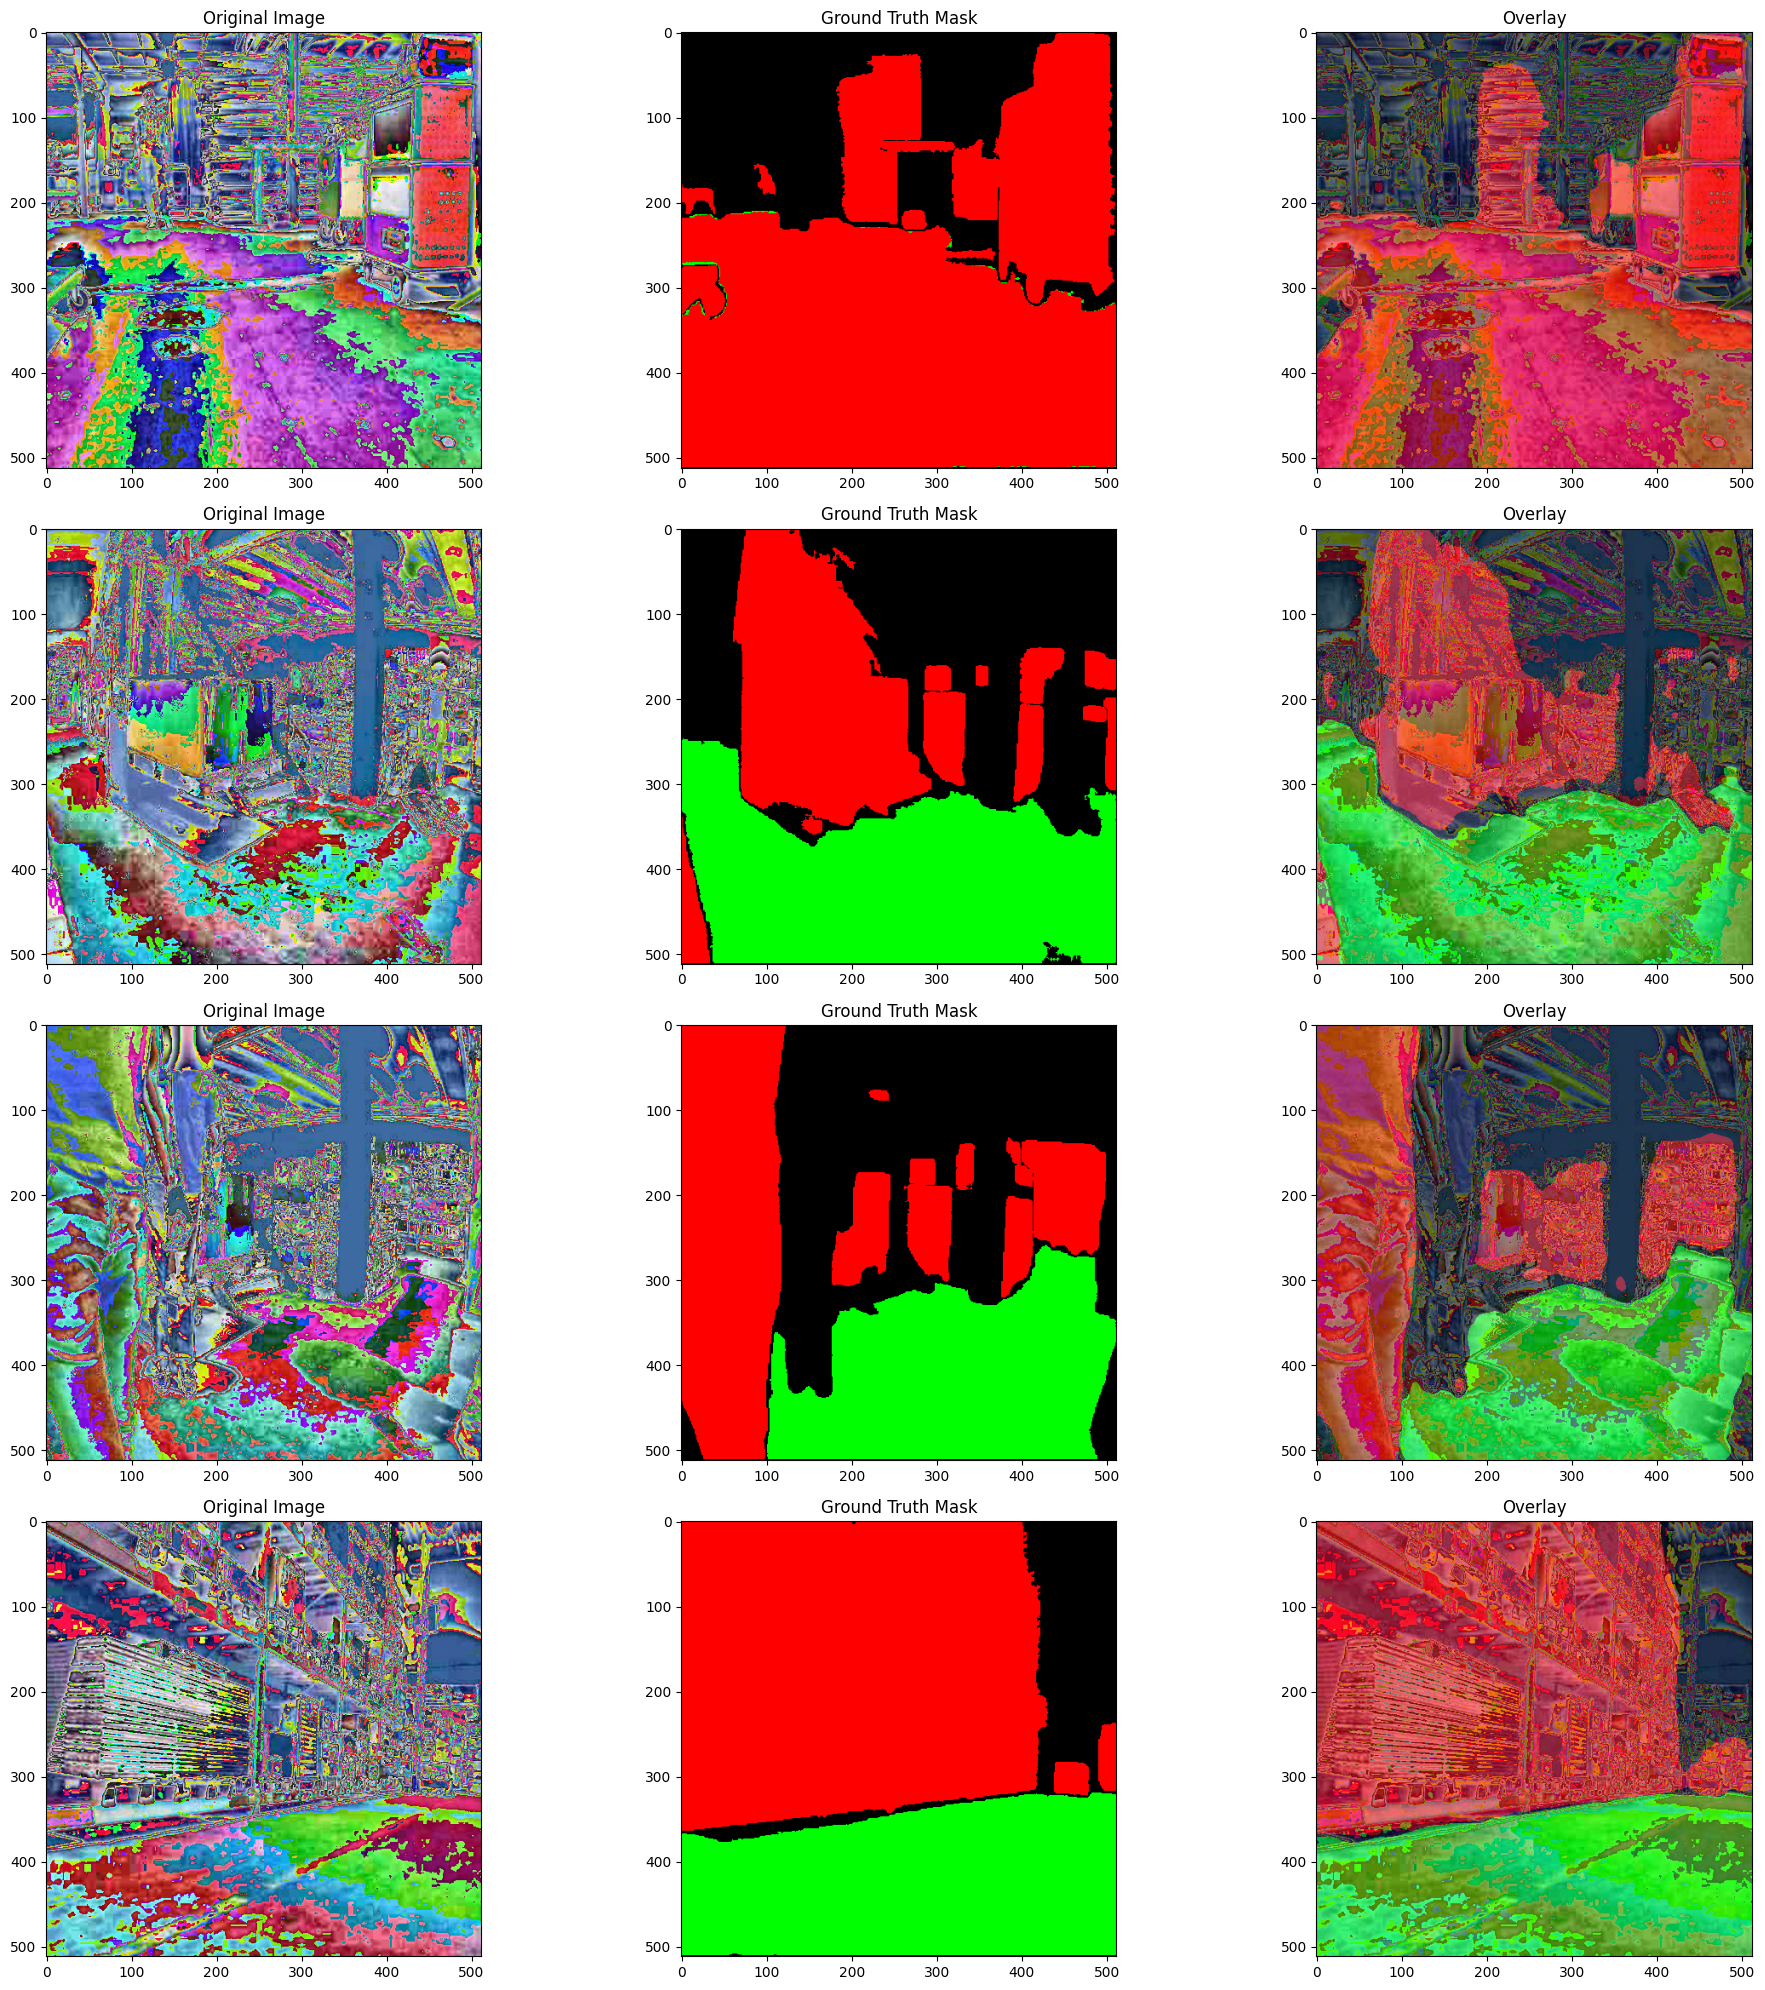

In [9]:
import matplotlib.pyplot as plt

color_map = {
    0: (0, 0, 0),        # Background - Black
    1: (0, 255, 0),      # Pallet - Green
    2: (255, 0, 0)       # Cement Floor - Red
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape, dtype=np.uint8)
    for class_id, color in color_map.items():
        vis[prediction == class_id] = color
    return Image.fromarray(vis)

def visualize_predictions(model, dataloader, n_plots=4):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch['pixel_values'], batch['labels']
            outputs = model(batch)
            upsampled_logits = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            images = images.cpu().numpy()

            f, axarr = plt.subplots(n_plots, 3, figsize=(20, 5 * n_plots))
            for i in range(n_plots):
                pred_mask_vis = prediction_to_vis(predicted_mask[i])
                gt_mask_vis = prediction_to_vis(masks[i])

                input_image = images[i].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
                input_image = (input_image * 255).astype(np.uint8)
                input_image_pil = Image.fromarray(input_image)

                overlay_img = Image.blend(input_image_pil.convert("RGBA"), pred_mask_vis.convert("RGBA"), 0.5)

                axarr[i, 0].imshow(input_image)
                axarr[i, 0].set_title("Original Image")
                axarr[i, 1].imshow(gt_mask_vis)
                axarr[i, 1].set_title("Ground Truth Mask")
                axarr[i, 2].imshow(overlay_img)
                axarr[i, 2].set_title("Overlay")
            
            plt.tight_layout()
            plt.show()
            break

visualize_predictions(model, test_loader, n_plots=4)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_17901/800312882.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, th

Model loaded successfully from checkpoint!


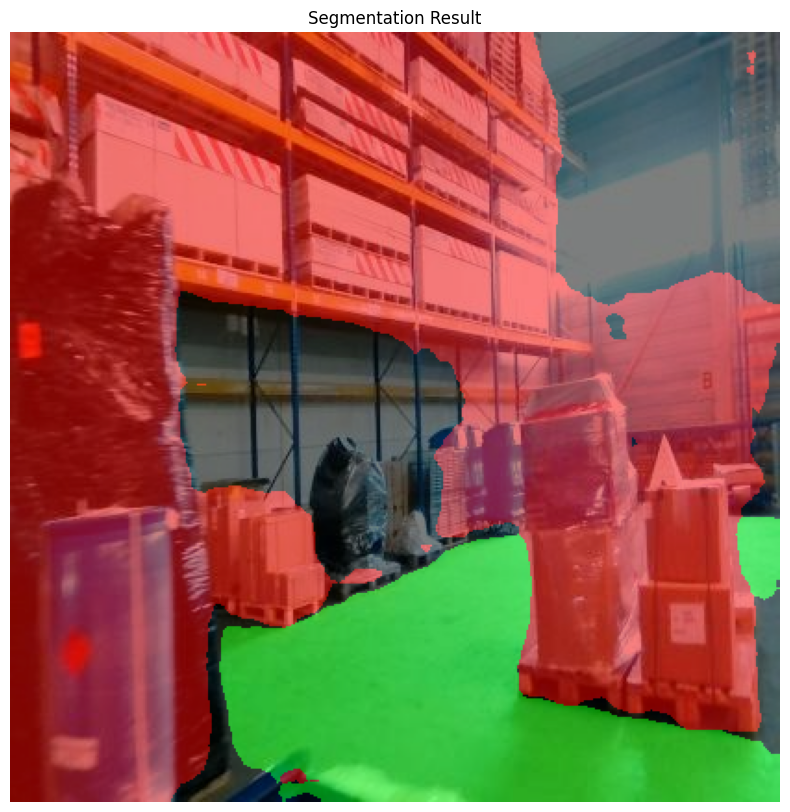

Output saved to /home/kishore/peer_ros2/src/segformer/Balloons-22/test/456_jpg.rf.f824626fbef48b39b6966d344685c51f.jpg


In [11]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2

# Define the color map for visualization
color_map = {
    0: (0, 0, 0),        # Background - Black
    1: (0, 255, 0),      # Pallet - Green
    2: (255, 0, 0)       # Cement Floor - Red
}

def prediction_to_vis(prediction):
    """
    Convert predicted mask to a visual format.
    """
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape, dtype=np.uint8)
    for class_id, color in color_map.items():
        vis[prediction == class_id] = color
    return vis

def preprocess_image(image_path, feature_extractor):
    """
    Preprocess a single image for the model.
    """
    image = Image.open(image_path).convert("RGB")
    encoded_inputs = feature_extractor(image, return_tensors="pt")
    pixel_values = encoded_inputs['pixel_values']
    return pixel_values, np.array(image)

import matplotlib.pyplot as plt

def infer_image(model, feature_extractor, image_path, output_path=None):
    """
    Perform inference on a single input image and display/save the results using matplotlib.
    """
    # Preprocess the image
    pixel_values, original_image = preprocess_image(image_path, feature_extractor)
    pixel_values = pixel_values.to(next(model.parameters()).device)

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits

        # Resize the logits to match the original image size
        upsampled_logits = F.interpolate(
            logits,
            size=original_image.shape[:2],  # Resize to (H, W)
            mode="bilinear",
            align_corners=False
        )
        predicted_mask = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()

    # Convert the predicted mask to a visual format
    mask_vis = prediction_to_vis(predicted_mask)

    # Resize the visual mask to match the original image dimensions
    mask_vis = Image.fromarray(mask_vis).resize((original_image.shape[1], original_image.shape[0]))
    mask_vis = np.array(mask_vis)

    # Blend the original image and the mask
    overlay = cv2.addWeighted(original_image, 0.5, mask_vis, 0.5, 0)

    # Display the result using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title("Segmentation Result")
    plt.axis("off")
    plt.show()

    # Optionally save the result
    if output_path:
        cv2.imwrite(output_path, overlay)
        print(f"Output saved to {output_path}")


# Initialize the feature extractor
feature_extractor = SegformerFeatureExtractor()

# Load your custom model checkpoint
checkpoint_path = "/home/kishore/peer_ros2/src/segformer/lightning_logs/version_7/checkpoints/epoch=9-step=1150.ckpt"
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-cityscapes-1024-1024",
    num_labels=3,  # Number of classes (background, pallet, cement floor)
    ignore_mismatched_sizes=True
)

# Load the checkpoint and extract state_dict
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint["state_dict"]
model.load_state_dict({k.replace("model.", ""): v for k, v in state_dict.items()})
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

print("Model loaded successfully from checkpoint!")

# Perform inference
image_path = "/home/kishore/peer_ros2/src/segformer/Balloons-22/train/456_jpg.rf.f824626fbef48b39b6966d344685c51f.jpg"  # Replace with your image path
output_path = "/home/kishore/peer_ros2/src/segformer/Balloons-22/test/456_jpg.rf.f824626fbef48b39b6966d344685c51f.jpg" # Optional output path

infer_image(model, feature_extractor, image_path, output_path=output_path)


/home/kishore/anaconda3/envs/segformer_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kishore/anaconda3/envs/segformer_env/lib/python3.9/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size

Model loaded successfully from checkpoint!


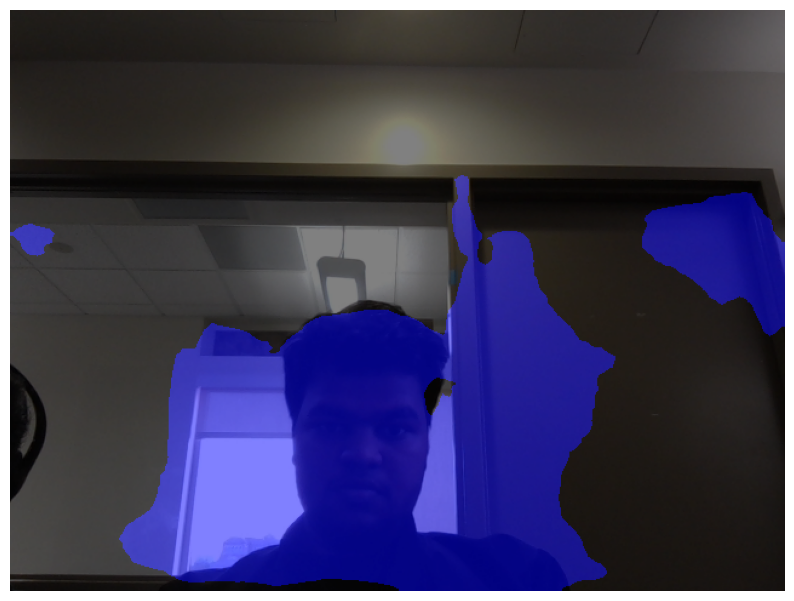

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [1]:
import cv2
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch.nn.functional as F
from PIL import Image
import numpy as np

# Define the color map for visualization
color_map = {
    0: (0, 0, 0),        # Background - Black
    1: (0, 255, 0),      # Pallet - Green
    2: (255, 0, 0)       # Cement Floor - Red
}

def prediction_to_vis(prediction):
    """
    Convert predicted mask to a visual format.
    """
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape, dtype=np.uint8)
    for class_id, color in color_map.items():
        vis[prediction == class_id] = color
    return vis

def preprocess_frame(frame, feature_extractor):
    """
    Preprocess a single video frame for the model.
    """
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    encoded_inputs = feature_extractor(pil_image, return_tensors="pt")
    pixel_values = encoded_inputs['pixel_values']
    return pixel_values

import matplotlib.pyplot as plt

def infer_webcam(model, feature_extractor):
    """
    Perform real-time segmentation on webcam feed and display results using matplotlib.
    """
    cap = cv2.VideoCapture(0)  # Open the default webcam
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    model.eval()
    with torch.no_grad():
        plt.ion()  # Enable interactive mode
        fig, ax = plt.subplots(figsize=(10, 10))
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame.")
                break

            # Preprocess the frame
            pixel_values = preprocess_frame(frame, feature_extractor)
            pixel_values = pixel_values.to(next(model.parameters()).device)

            # Perform inference
            outputs = model(pixel_values)
            logits = outputs.logits

            # Resize the logits to match the frame size
            upsampled_logits = F.interpolate(
                logits,
                size=frame.shape[:2],  # (height, width)
                mode="bilinear",
                align_corners=False
            )
            predicted_mask = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()

            # Convert the predicted mask to a visual format
            mask_vis = prediction_to_vis(predicted_mask)

            # Resize mask to match the frame
            mask_vis = cv2.resize(mask_vis, (frame.shape[1], frame.shape[0]))

            # Blend the original frame and the mask
            overlay = cv2.addWeighted(frame, 0.5, mask_vis, 0.5, 0)

            # Update the matplotlib plot
            ax.clear()
            ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            ax.axis("off")
            plt.draw()
            plt.pause(0.001)  # Pause to allow plot updates

            # Break on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        plt.ioff()  # Disable interactive mode
        plt.show()

    cap.release()


# Initialize the feature extractor
feature_extractor = SegformerFeatureExtractor()

# Load your custom model checkpoint
checkpoint_path = "/home/kishore/peer_ros2/src/segformer/lightning_logs/version_7/checkpoints/epoch=9-step=1150.ckpt"
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-cityscapes-1024-1024",
    num_labels=3,  # Number of classes (background, pallet, cement floor)
    ignore_mismatched_sizes=True
)

# Load the checkpoint and extract state_dict
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint["state_dict"]
model.load_state_dict({k.replace("model.", ""): v for k, v in state_dict.items()})
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

print("Model loaded successfully from checkpoint!")

# Perform inference on webcam feed
infer_webcam(model, feature_extractor)
